In [57]:
using Flux
using BSON: @load
using Chemfiles
using Plots

struct G2
    eta::Float64
    rcutoff::Float64
    rshift::Float64
end

function build_distance_matrix(frame)
    N = length(frame)
    return [distance(frame, i - 1, j - 1) for i in 1:N, j in 1:N]
end

function distance_cutoff(d, rcutoff=10.0)
    return d > rcutoff ? 0.0 : 0.5 * (cos(π * d / rcutoff) + 1.0)
end

function compute_g2(distances, eta, rcutoff, rshift)
    return sum(exp(-eta * (d - rshift)^2) * distance_cutoff(d, rcutoff) for d in distances if d > 0.0)
end

function build_g2_matrix(distance_matrix, g2_functions)
    N = size(distance_matrix, 1)
    g2_matrix = zeros(Float64, N, length(g2_functions))
    for i in 1:N
        distances = distance_matrix[i, :]
        for (j, g2_func) in enumerate(g2_functions)
            g2_matrix[i, j] = compute_g2(distances, g2_func.eta, g2_func.rcutoff, g2_func.rshift)
        end
    end
    return g2_matrix
end

build_g2_matrix (generic function with 1 method)

Analyze best result with new version

In [58]:
g2_list = [
    G2(0.000, 15.0, 0.00),
    G2(0.000, 5.50, 0.00),
    G2(10.456, 15.0, 3.00),
    G2(10.456, 15.0, 3.50),
    G2(10.456, 15.0, 4.00),
    G2(10.456, 15.0, 4.50),
    G2(10.456, 15.0, 5.00),
    G2(10.456, 15.0, 5.50),
    G2(10.456, 15.0, 6.00),
 ]


9-element Vector{G2}:
 G2(0.0, 15.0, 0.0)
 G2(0.0, 5.5, 0.0)
 G2(10.456, 15.0, 3.0)
 G2(10.456, 15.0, 3.5)
 G2(10.456, 15.0, 4.0)
 G2(10.456, 15.0, 4.5)
 G2(10.456, 15.0, 5.0)
 G2(10.456, 15.0, 5.5)
 G2(10.456, 15.0, 6.0)

In [59]:
traj = Trajectory("10Bu200step.xtc")
steps = length(traj)
reference_input = zeros(length(g2_list))
for i in 1:steps
    frame = read(traj)
    distance_mat = build_distance_matrix(frame)
    g2_mat = build_g2_matrix(distance_mat, g2_list)
    acc_vec = zeros(length(g2_list))
        for row in 1:length(g2_mat[:, 1])
            acc_vec .+= g2_mat[row, :]
        end
    reference_input .+= acc_vec / length(g2_mat[:, 1])
    end

reference_input = reference_input / steps

9-element Vector{Float64}:
 12.30243411459869
  0.20949395483890032
  0.06243498973004161
  0.08989208640978126
  0.1872136261615849
  0.480960167769088
  0.8467409983855325
  1.0413003682166089
  1.0649637174394784

In [60]:
MODEL_PATH = "model-iter-47.bson"
@load MODEL_PATH model
e_reference = model(reference_input)[1]

-45.9633934091875

Get the change of energy when ignoring the input of the ith symmetry function

In [61]:
delta_e = zeros(length(g2_list))
for i in 1:length(g2_list)
    input_vec = copy(reference_input)
    input_vec[i] = 0
    energy = model(input_vec)[1]
    delta_e[i] = e_reference - energy
end

delta_e = abs.(delta_e)


9-element Vector{Float64}:
 10.173531959194278
  6.477674937005112
  0.5408496580876587
  0.1905738996090065
  0.23535177767113424
  0.39475460220810277
  0.017782306178659724
  0.14215314993809613
  0.26631966785173944

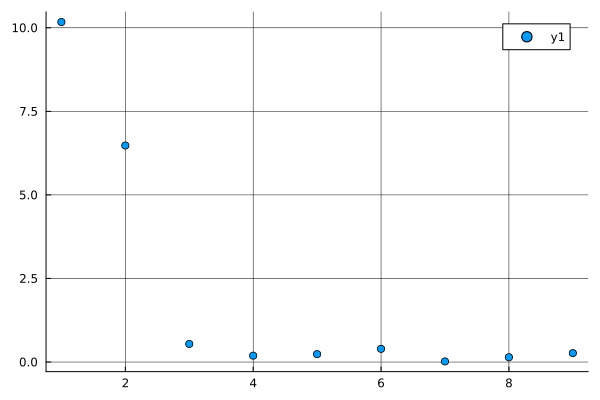

In [62]:
plot(delta_e, seriestype = [:scatter], grid = true, gridalpha = 2, gridcolor = :black)

Analyze best model of old version 

In [63]:
g2_list = [

G2( 0.000, 10.0, 0.00),
G2( 0.050, 10.0, 0.00),
G2(0.050, 10.0, 3.00),
G2(0.050, 10.0, 6.00),

G2( 4.000, 10.0, 3.00),
G2(4.000, 10.0, 3.50),
G2( 4.000, 10.0, 4.00),
G2( 4.000, 10.0, 4.50),
G2( 4.000, 10.0, 5.00),
G2( 4.000, 10.0, 5.50),
G2( 4.000, 10.0, 6.00),


G2(10.0, 10.0, 4.10),
G2(10.0, 10.0, 4.30),
G2(10.0, 10.0, 4.90),
G2(10.0, 10.0, 5.70),
G2(10.0, 10.0, 6.80),
G2(10.0, 10.0, 8.80),
G2(10.0, 10.0, 9.80)
]


18-element Vector{G2}:
 G2(0.0, 10.0, 0.0)
 G2(0.05, 10.0, 0.0)
 G2(0.05, 10.0, 3.0)
 G2(0.05, 10.0, 6.0)
 G2(4.0, 10.0, 3.0)
 G2(4.0, 10.0, 3.5)
 G2(4.0, 10.0, 4.0)
 G2(4.0, 10.0, 4.5)
 G2(4.0, 10.0, 5.0)
 G2(4.0, 10.0, 5.5)
 G2(4.0, 10.0, 6.0)
 G2(10.0, 10.0, 4.1)
 G2(10.0, 10.0, 4.3)
 G2(10.0, 10.0, 4.9)
 G2(10.0, 10.0, 5.7)
 G2(10.0, 10.0, 6.8)
 G2(10.0, 10.0, 8.8)
 G2(10.0, 10.0, 9.8)

In [66]:
traj = Trajectory("10Bu200step.xtc")
steps = length(traj)
reference_input = zeros(length(g2_list))
for i in 1:steps
    frame = read(traj)
    distance_mat = build_distance_matrix(frame)
    g2_mat = build_g2_matrix(distance_mat, g2_list)
    acc_vec = zeros(length(g2_list))
        for row in 1:length(g2_mat[:, 1])
            acc_vec .+= g2_mat[row, :]
        end
    reference_input .+= acc_vec / length(g2_mat[:, 1])
    end

reference_input = reference_input / steps

18-element Vector{Float64}:
 3.498017465351354
 0.7611587432155534
 2.2796258732596613
 3.2084773798017725
 0.08919375711948445
 0.1328329315244736
 0.26731348806852545
 0.5623361765457753
 0.8675189316603336
 0.9760108147831079
 0.8977456634306219
 0.17834569063716232
 0.25645364558620803
 0.5385642800719175
 0.6208375368228111
 0.3891333412122482
 0.08062313264328576
 0.0062231515633199746

In [67]:
MODEL_PATH = "model-iter-98.bson"
@load MODEL_PATH model
e_reference = model(reference_input)[1]

-18.579497061244926

In [68]:
delta_e = zeros(length(g2_list))
for i in 1:length(g2_list)
    input_vec = copy(reference_input)
    input_vec[i] = 0
    energy = model(input_vec)[1]
    delta_e[i] = e_reference - energy
end

delta_e = abs.(delta_e)

18-element Vector{Float64}:
  15.465244698590656
  33.108405907723665
 133.06640285773486
  19.520697526966764
   0.010134740356544825
   0.8914354517389214
   1.203840092006498
   1.6573380700452383
   1.5814571399534074
   0.41725216616828575
   0.10959955670199051
   0.00043165036640147036
   0.017953444402856178
   0.005233039160593478
   0.14691135243910836
   0.14818836544555936
   0.021162134257021847
   0.000582896996462523

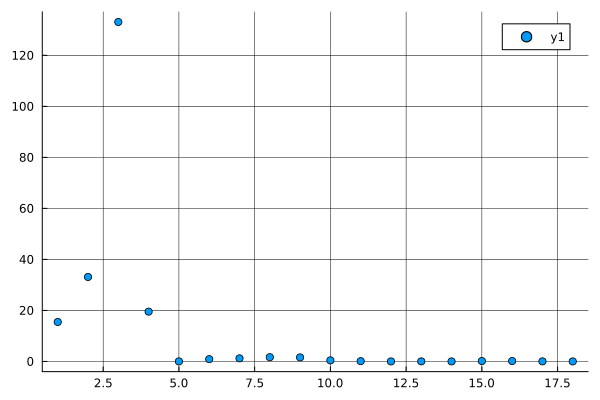

In [69]:
plot(delta_e, seriestype = [:scatter], grid = true, gridalpha = 2, gridcolor = :black)
